# Большая лабораторная

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from imageio import imread, imsave
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu, rank, try_all_threshold, threshold_li, threshold_local
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import watershed, binary_erosion, binary_opening, disk, binary_closing


## Загрузка данных

Выведем на экран 5 фотографий, для которых должен быть ответ "да" и столько же фотографий с ответом "нет":

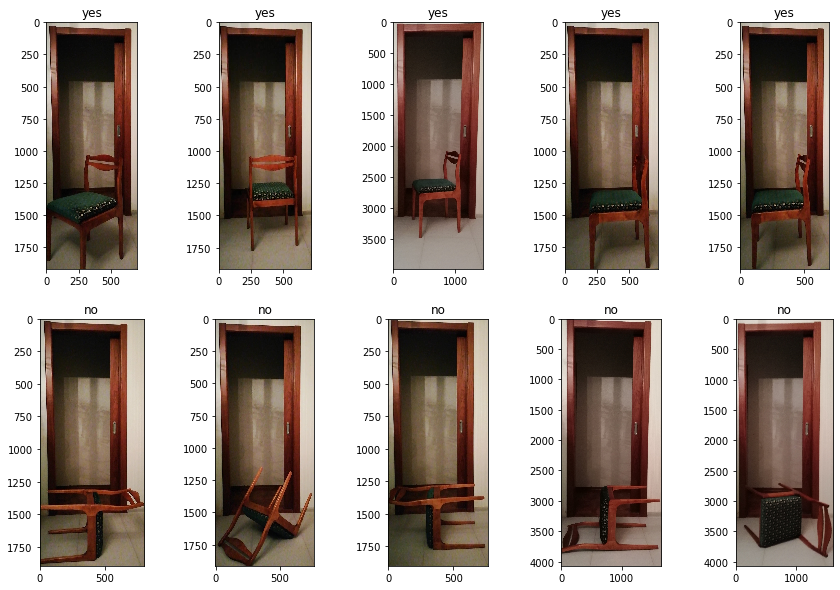

In [2]:
directory = "data/test"
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
images_yes = []
images_no  = []

for i in range(1 * 5):
    label = "yes"
    filename = str(i + 1) + ".jpg"
    path = os.path.join(directory, label, filename)
    images_yes.append(imread(path))
    ax.flatten()[i].set_title(label)
    ax.flatten()[i].imshow(images_yes[i])

for i in range(1 * 5):
    label = "no"
    filename = str(i + 1) + ".jpg"
    path = os.path.join(directory, label, filename)
    images_no.append(imread(path))
    ax.flatten()[i + 5].set_title(label)
    ax.flatten()[i + 5].imshow(images_no[i])

Также загрузим фотографии стула без дверного проёма:

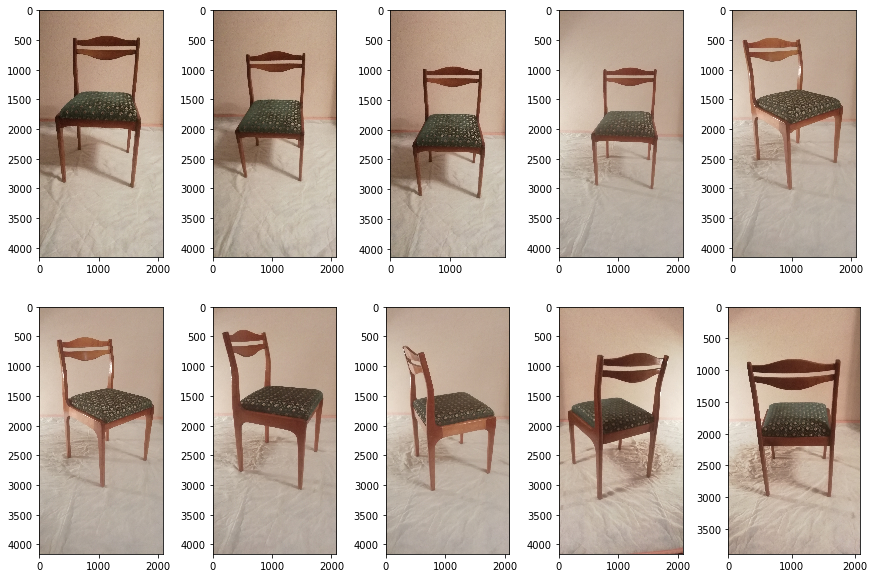

In [3]:
directory_templates = "data/single_chair"
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
single_chair = []

for i in range(2 * 5):
    filename = str(i + 1) + ".jpg"
    path = os.path.join(directory_templates, filename)

    single_chair.append(imread(path))
    ax.flatten()[i].imshow(single_chair[i])

Теперь загрузим фотографию дверного проёма без стула:

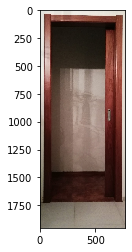

In [4]:
door = imread("data/single_door/1.jpg")
plt.imshow(door)

## Метод Канни

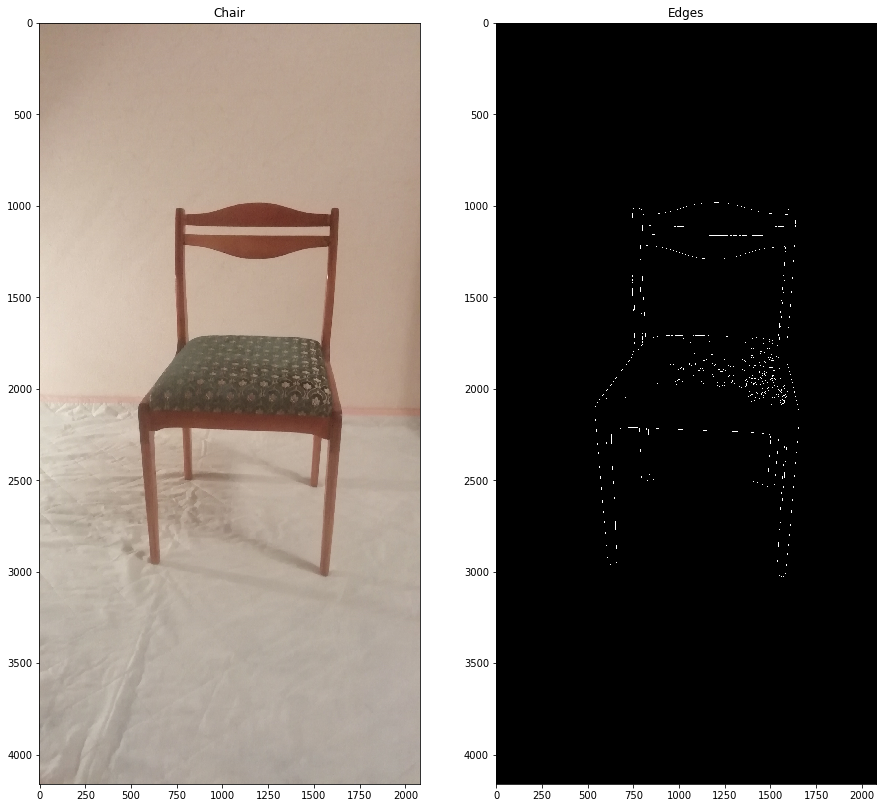

In [5]:
chair = single_chair[3]
chair_gray = rgb2gray(chair)

chair_edges = canny(chair_gray, sigma=2)

f, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].set_title("Chair")
ax[1].set_title("Edges")
ax[0].imshow(chair)
ax[1].imshow(chair_edges, cmap="gray")

Границы стула выделяются пусть и правильно, но слишком прерывисто. Попробуем предобработать изображение с помощью бинаризации:

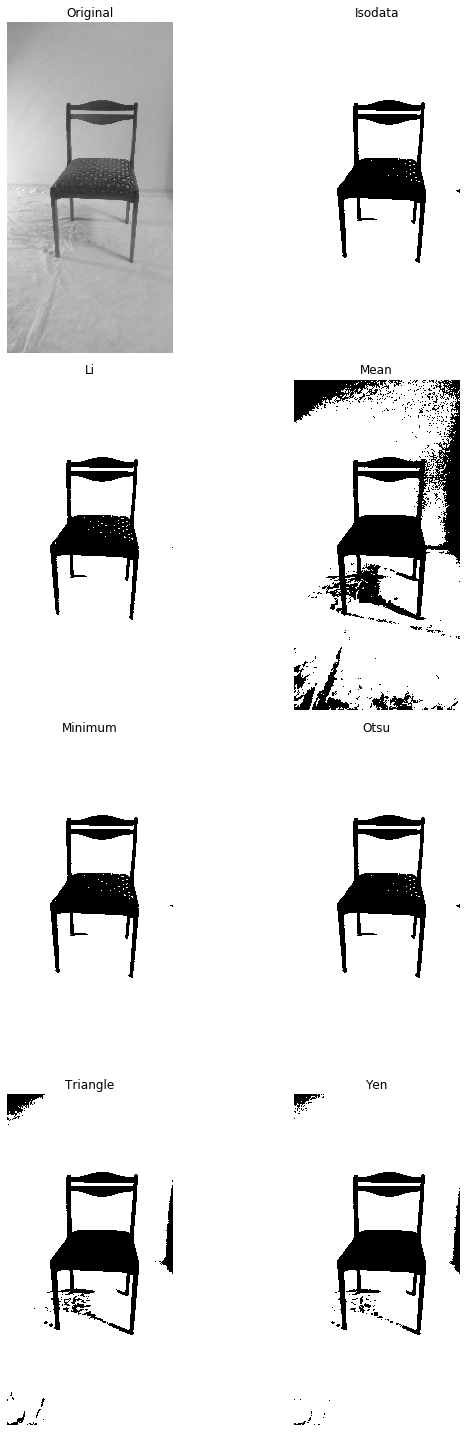

In [6]:
fig, ax = try_all_threshold(rgb2gray(chair), figsize=(10, 20), verbose=False)
plt.show()

Лучше всего получилось с фильтром Ли.

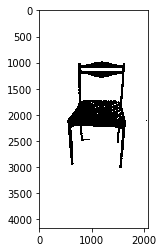

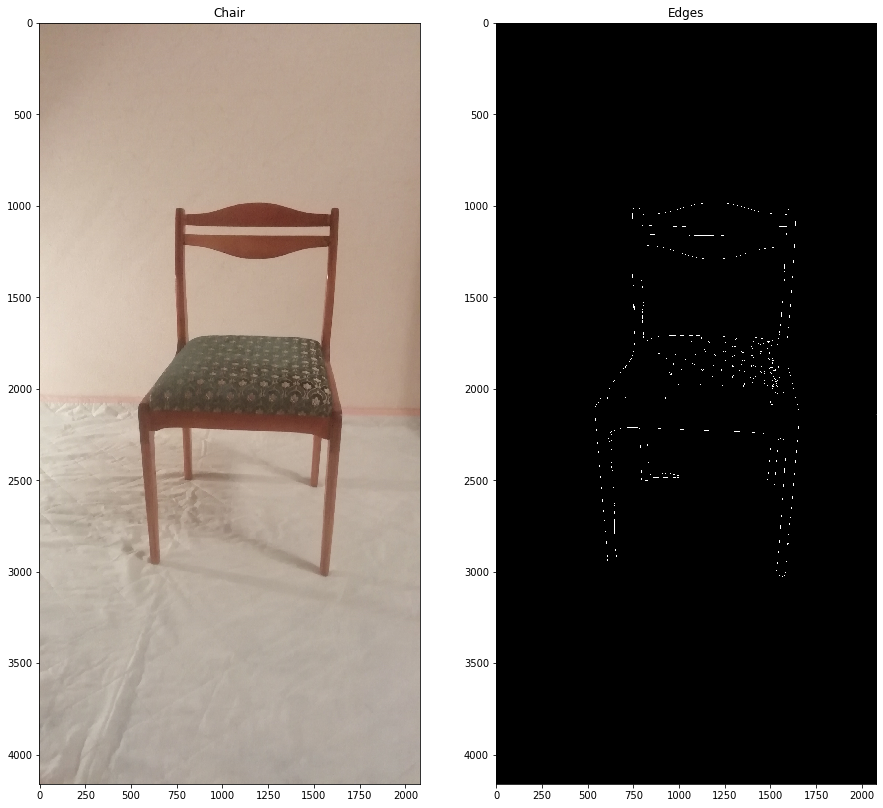

In [7]:
binary_chair_gray = rgb2gray(chair)
threshold = threshold_li(binary_chair_gray)

binary_chair = binary_chair_gray > threshold

plt.imshow(binary_chair, cmap='gray')
plt.show()

binary_chair_edges = canny(binary_chair, sigma=2)

f, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].set_title("Chair")
ax[1].set_title("Edges")
ax[0].imshow(chair, cmap="gray")
ax[1].imshow(binary_chair_edges, cmap="gray")

Видим, что бинаризация не помогла.
Можно попробовать морфологические операции:

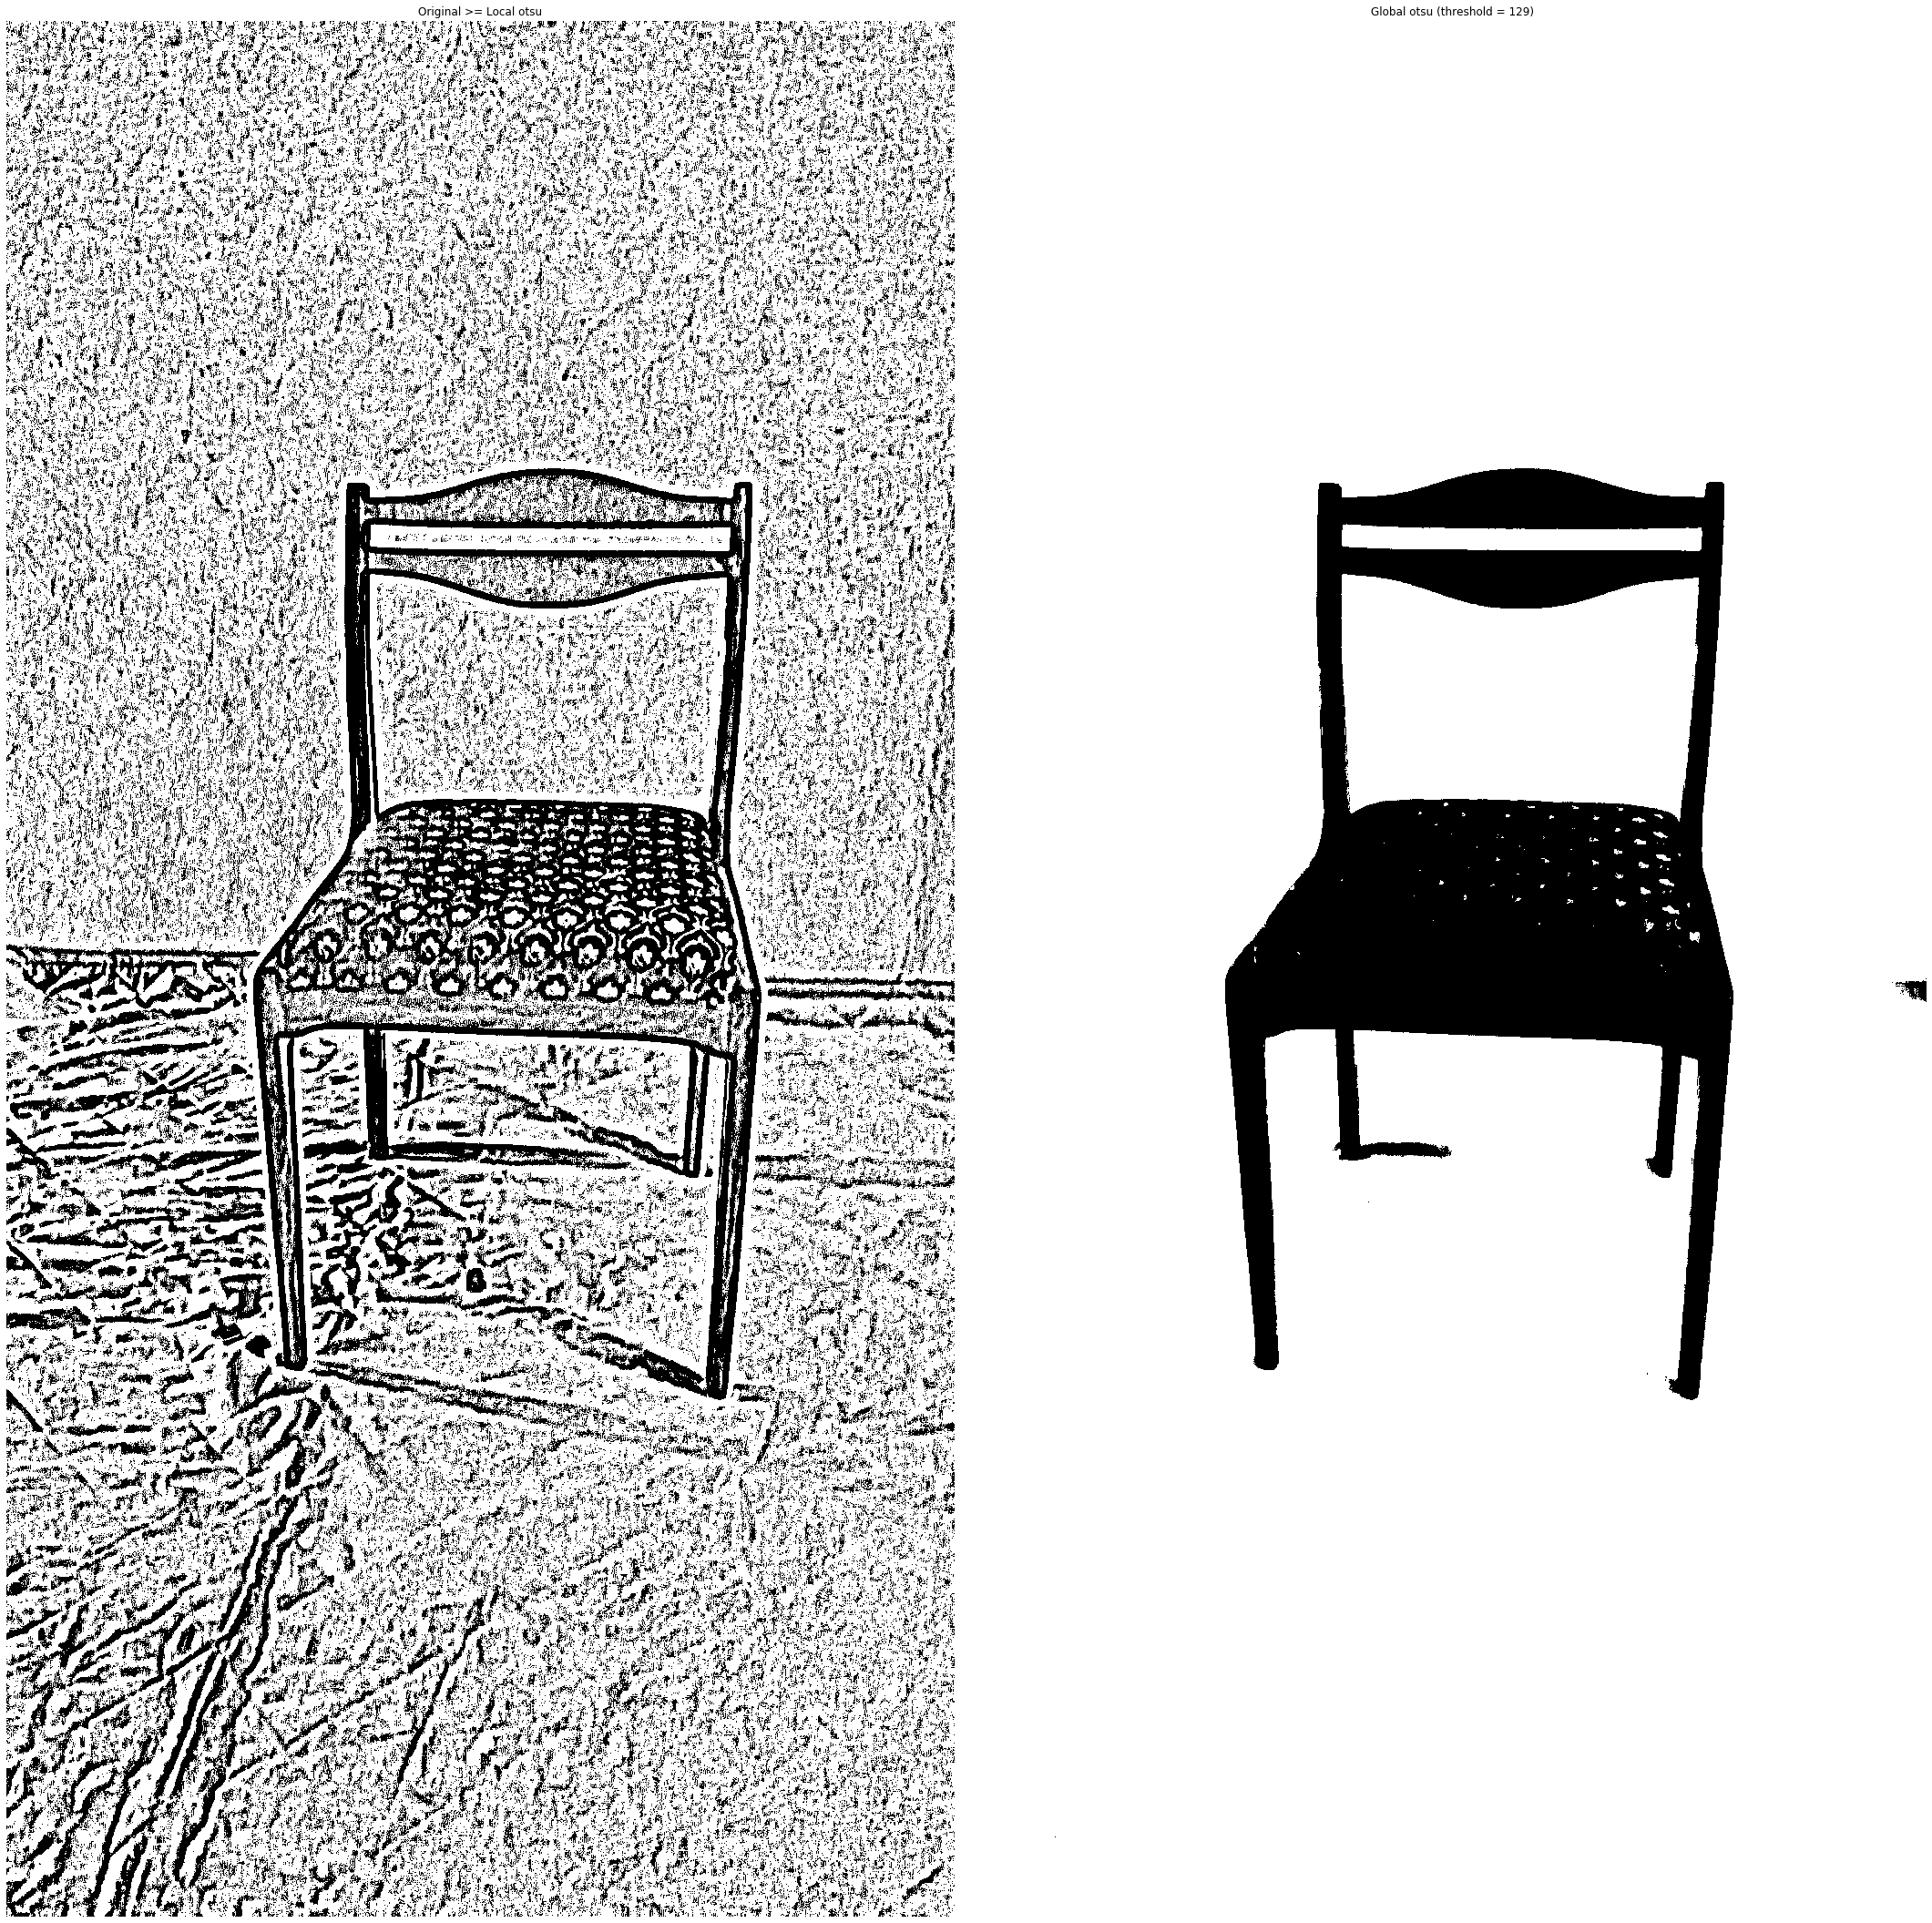

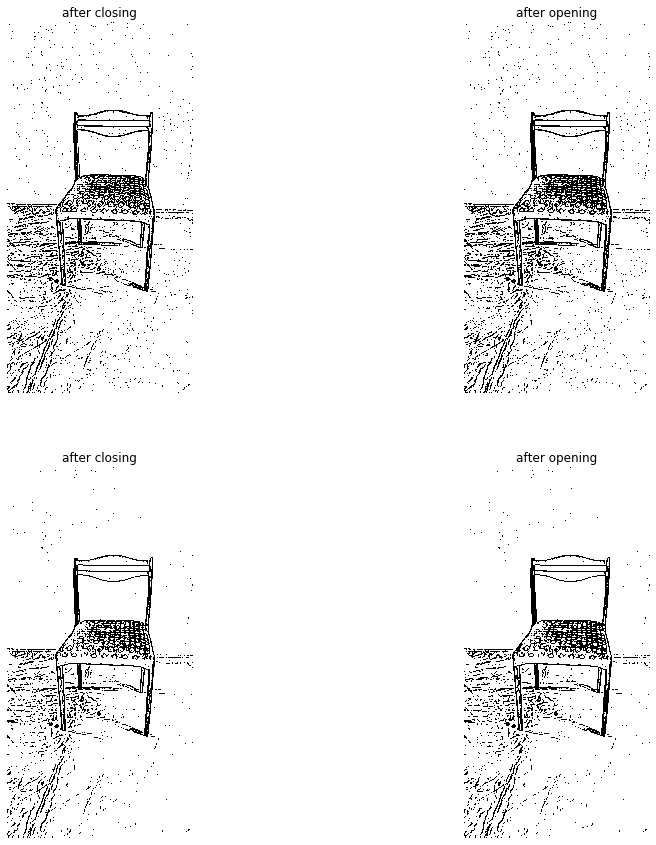

In [8]:
data_img_gray = rgb2gray(chair)
img = img_as_ubyte(data_img_gray)
radius = 15
selem = disk(radius)
local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, ax = plt.subplots(1, 2, figsize=(30, 30), sharex=True, sharey=True)
ax2, ax3 = ax.ravel()
plt.tight_layout()

img_local_otsu = img >= local_otsu
ax2.imshow(img_local_otsu, cmap="gray")
ax2.set_title('Original >= Local otsu' % threshold_global_otsu)
ax2.axis('off')

ax3.imshow(global_otsu, cmap="gray")
ax3.set_title('Global otsu (threshold = %d)' % threshold_global_otsu)
ax3.axis('off')

plt.show()

tmp_img = img_local_otsu

tmp_res_otsu_close = binary_closing(tmp_img, selem=np.ones((5, 5)))
tmp_res_otsu_open = binary_opening(tmp_res_otsu_close, selem=np.ones((7, 7)))


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax0, ax1, ax2, ax3 = ax.ravel()
ax0.axis('off')
ax1.axis('off')
ax0.set_title("after closing")
ax1.set_title("after opening")
ax0.imshow(tmp_res_otsu_close, cmap="gray")
ax1.imshow(tmp_res_otsu_open, cmap="gray")


img_local_otsu_blur = gaussian(tmp_res_otsu_open, sigma=0.5, multichannel=True)

tmp_res_otsu_open_2 = binary_closing(img_local_otsu_blur, selem=np.ones((5, 5)))
tmp_res_otsu_close_2 = binary_opening(tmp_res_otsu_open_2, selem=np.ones((10, 10)))

ax2.axis('off')
ax3.axis('off')
ax2.set_title("after closing")
ax3.set_title("after opening")
ax2.imshow(tmp_res_otsu_open_2, cmap="gray")
ax3.imshow(tmp_res_otsu_close_2, cmap="gray")
plt.show()

img_res_otsu_morph = tmp_res_otsu_open

Всё же границы стула ДО применения бинаризации и морфологии можно считать приемлемыми для использования. Можно итерироваться по полученной матрице и найти ширину и высоту стула. 
Но получится ли выделить стул с помощью фильтра Канни на более сложном входном изображении, где есть и стул, дверь, разнородный фон и тени?  

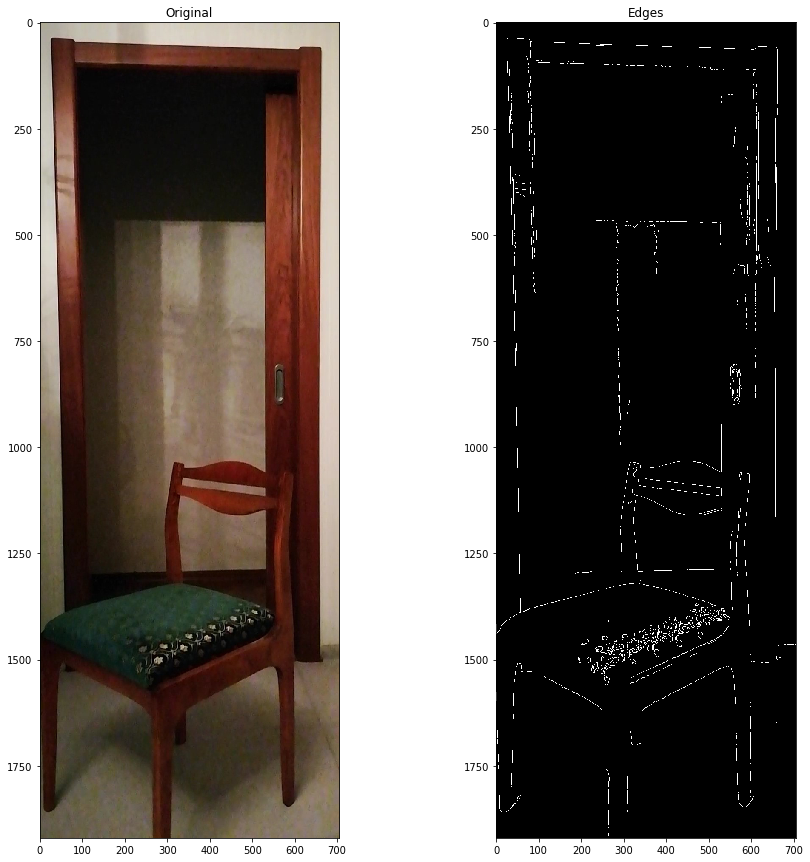

In [9]:
img = images_yes[0]
img_gray = rgb2gray(img)

img_edges = canny(img_gray, sigma=1)

f, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].set_title("Original")
ax[1].set_title("Edges")
ax[0].imshow(img)
ax[1].imshow(img_edges, cmap="gray")

Видно, что получилось выделить границы стула и дверного проёма. Но по матрице `img_edges` никак не определить, какие границы относятся к стулу, какие к двери, а какие - ни к тому, ни к другому. Так что метод Канни оставляем "в запасе"

## Выделение особых точек с помощью ORB детектора

Возьмём кадр, где есть только cтул, и найдём на нём особые точки. На втором кадре (стул + дверной проём) попробуем найти стул по особым точкам.

Шаблон стула обрежем так, чтобы стул заполнял всю картинку:

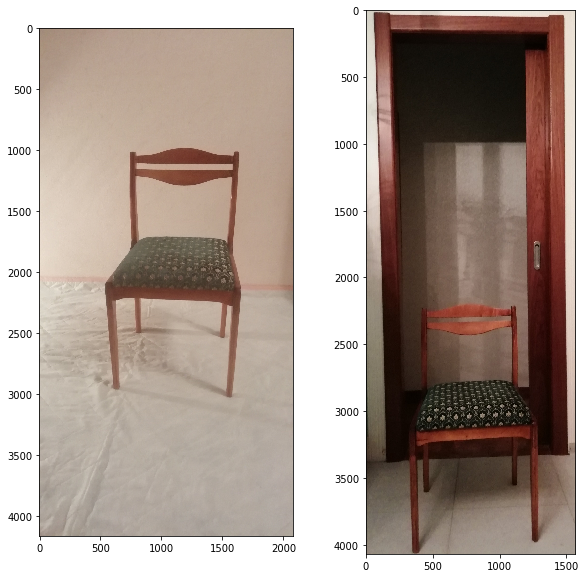

In [10]:
path1 = 'data/single_chair/4.jpg'
path2 = 'data/test/yes/11.jpg'

frame1 = imread(path1)
frame2 = imread(path2)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(frame1)
ax[1].imshow(frame2)

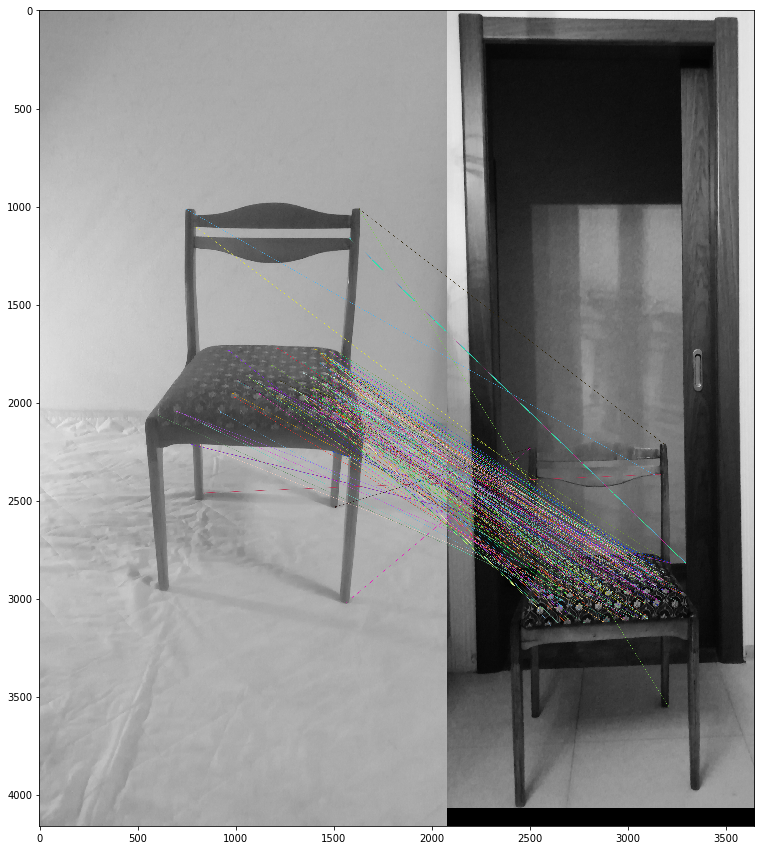

In [11]:
src = cv2.cvtColor(cv2.imread(path1) , cv2.COLOR_BGR2GRAY)
dst = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2GRAY)

orb_detector = cv2.ORB_create(nfeatures=100000)
kp1, des1 = orb_detector.detectAndCompute(src, None)
kp2, des2 = orb_detector.detectAndCompute(dst, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(des1, des2)

matches = sorted(matches, key=lambda x:x.distance)

good_matches = []
for m in matches:
    if m.distance < 40:
        good_matches.append(m)
         
img_matches = cv2.drawMatches(src, kp1, dst, kp2, good_matches, None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 15))
plt.imshow(img_matches, interpolation='nearest')


plt.show()




Стул распознаётся правильно. 

Направления работы в дальнейшем:

1. Придумать, как автоматически выбирать наиболее подходящий шаблон стула для входной картинки
2. Используя данные, полученные в п.1, найти примерные геом. размеры стула
3. Придумать, как распознать дверь
4. Найти примерные геом. размеры двери
5. Дать ответ на задачу


Попробуем выбрать "наилучший" шаблон стула для входной картинки. Критерий - максимум "хороших" совпадений. Совпадения "хорошие", если метрика distance не превосходит порог.

С использованием выбранного шаблона попробуем посчитать ширину стула относительно ширины картинки.

In [12]:
def find_chair_width(best_matches, kp_best, image):
    x_list = []
    
    for m in best_matches: 
        (x2, y2) = kp_best[m.trainIdx].pt  
          
        # знаем, что стул находится примерно в нижней части картинки
        # средняя высота двери - 200 см, а стула - 90 см. Отношение даёт 0.45
        chair_ratio = 0.45 
        y_up = (1 - chair_ratio) * image.shape[0]
        
        if y2 > y_up:
            x_list.append(x2)

    x_list.sort()


    x_min = x_list[0]
    x_max = x_list[-1]
    
    w = (x_max - x_min) / image.shape[1]
    return w

def try_all_templates(dst, figsize, threshold, templates_total, 
                      templates_path, output_info=False, output_graphics=True):
    
    max_good_matches = 0
    best_path = "/null"
    best_matches = []
    kp_src_best = []
    kp_dst_best = []
    
    for n in range(1, templates_total + 1):
        filename = str(n) + ".jpg"
        path1 = os.path.join(templates_path, filename)
       
        src = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2GRAY)
    
        orb_detector = cv2.ORB_create(nfeatures=10000)
        kp_src, des_src = orb_detector.detectAndCompute(src, None)
        kp_dst, des_dst = orb_detector.detectAndCompute(dst, None)

        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = matcher.match(des_src, des_dst)

        good_matches = []
        good_matches_total = 0
        for m in matches:
            if m.distance <= threshold:
                good_matches.append(m)
                good_matches_total += 1
                
        if output_info:
            print("chair template %d, matches: %d" % (n, good_matches_total))
    
        if good_matches_total > max_good_matches:
            max_good_matches = good_matches_total
            best_matches = good_matches
            best_path = path1
            kp_src_best = kp_src
            kp_dst_best = kp_dst
    
    src = cv2.cvtColor(cv2.imread(best_path), cv2.COLOR_BGR2GRAY)
    img_matches = cv2.drawMatches(src, kp_src_best, dst, kp_dst_best, best_matches, 
                                  None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
    if output_graphics:
        plt.figure(figsize=figsize)
        plt.imshow(img_matches, interpolation='nearest')
        plt.show()
        
    if output_info:   
        print("Best path is: ", best_path)
    
    return find_chair_width(best_matches, kp_dst_best, dst)

chair template 1, matches: 3411
chair template 2, matches: 3040
chair template 3, matches: 4292
chair template 4, matches: 1524
chair template 5, matches: 3104
chair template 6, matches: 3939
chair template 7, matches: 1861
chair template 8, matches: 1297
chair template 9, matches: 751
chair template 10, matches: 2145
chair template 11, matches: 2538
chair template 12, matches: 194
chair template 13, matches: 734
chair template 14, matches: 887
chair template 15, matches: 3424
chair template 16, matches: 3097
chair template 17, matches: 4300
chair template 18, matches: 1598
chair template 19, matches: 3154
chair template 20, matches: 1857
chair template 21, matches: 1323
chair template 22, matches: 756
chair template 23, matches: 2580
chair template 24, matches: 733
chair template 25, matches: 905


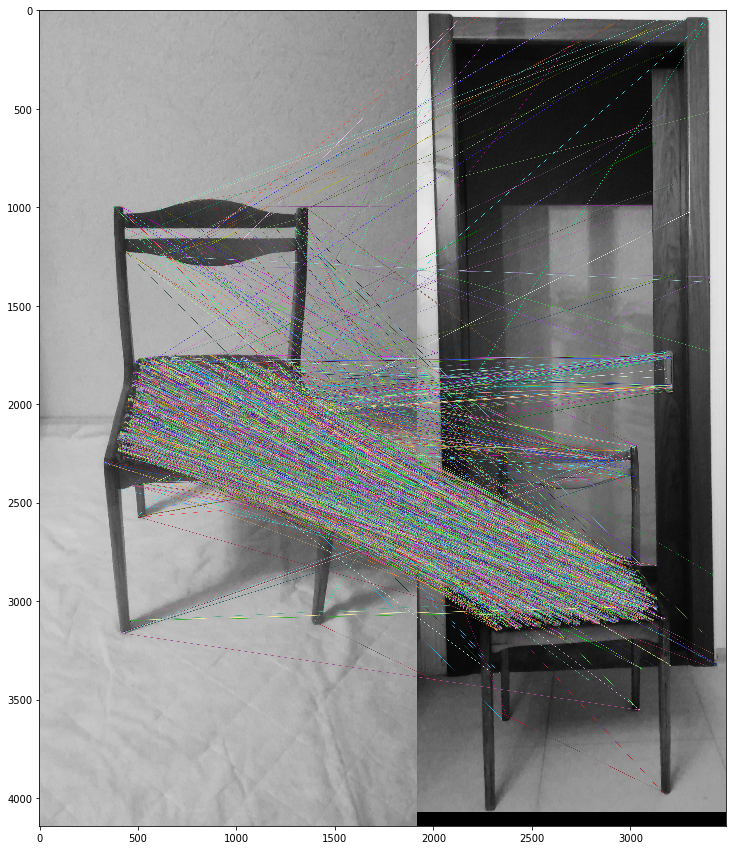

Best path is:  data/single_chair\17.jpg
chair width:  0.8845663265306123


In [13]:
path = 'data/test/yes/11.jpg'
dst = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

GOOD_MATCH_THRESHOLD = 200    

w = try_all_templates(dst, output_info=True, output_graphics=True,
                      figsize=(15, 15), threshold=GOOD_MATCH_THRESHOLD, templates_total=25, 
                      templates_path=directory_templates)

print("chair width: ", w)

Эксперимент удался! Но что будет для другой входной картинки?

test № 1


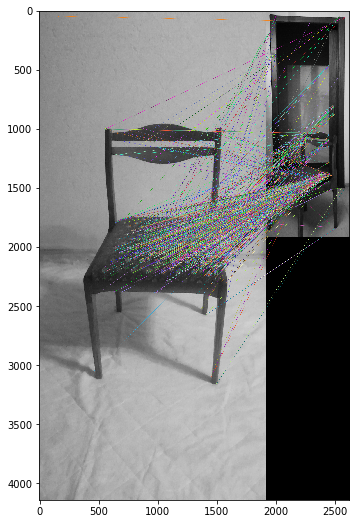

test № 2


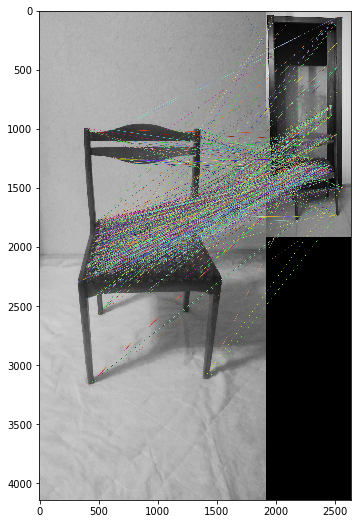

test № 3


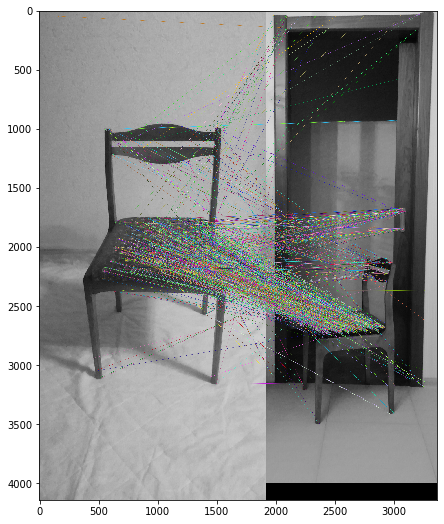

test № 4


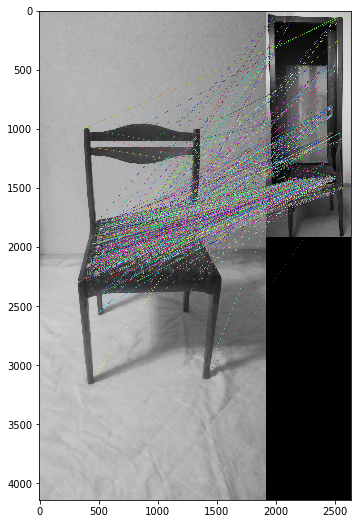

test № 5


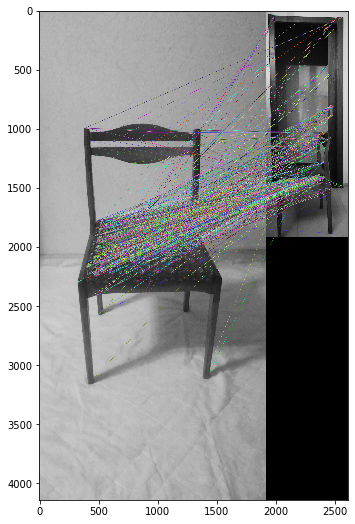

[0.8973050164838209, 0.6052817129491099, 0.8911479934122553, 0.6642453938350598, 0.8972503617945007]


In [14]:
def find_each_chair_width(label, sample_size, output=False):
    width_list = []
    for n in range(0, sample_size):
        filename = str(n + 1) + ".jpg"
        path = os.path.join(directory, label, filename)
        dst = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        print("test №", n+1)
    
        w = try_all_templates(dst, output_graphics=output, output_info=False, 
                              figsize=(9, 9), threshold=GOOD_MATCH_THRESHOLD, templates_total=25, 
                              templates_path=directory_templates)
        width_list.append(w)
        
    return width_list

label = "yes"
sample_size_yes = 5 
width_list = find_each_chair_width(label, sample_size_yes, output=True)
print(width_list)

Конечно, далёко не идеально получилось. Однако по картинкам видно, что в принципе во всех 5 случаях можно узнать примерную ширину стула (особенно зная, что он находится внизу картинки). Это и нужно в задаче. Стул по высоте обязан пролезать в проём.

Надо ещё посмотреть для картинок с ответом "no":

test № 1


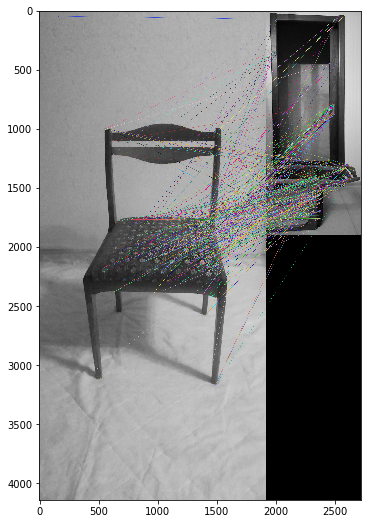

test № 2


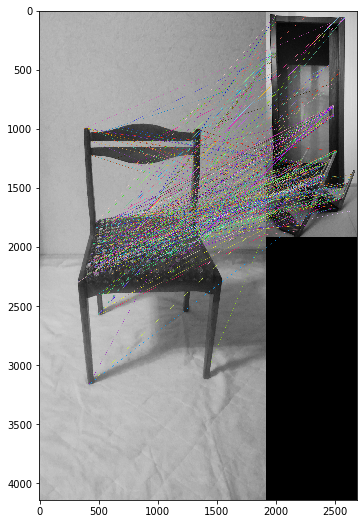

test № 3


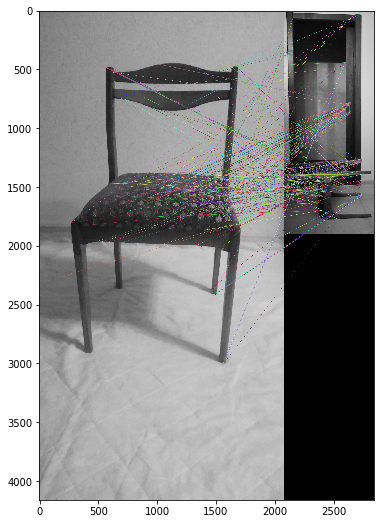

test № 4


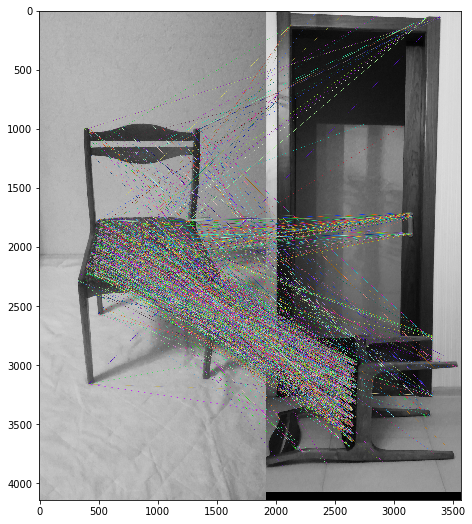

test № 5


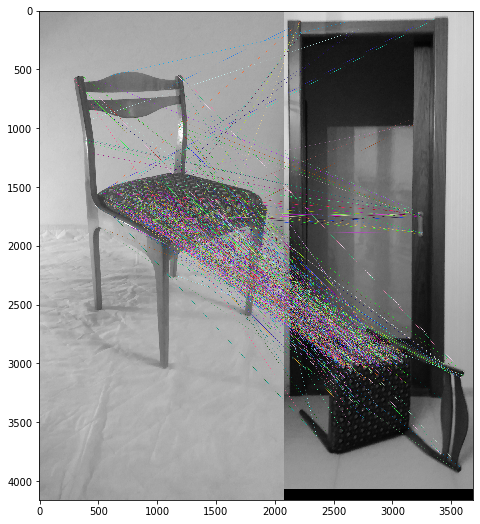

[0.8839900808738651, 0.8865710560625815, 0.83203125, 0.9533898305084746, 0.8674118582545933]


In [15]:
sample_size_no = 5 
label = "no"
width_list = find_each_chair_width(label, sample_size_no, output=True)
print(width_list)

В целом для картинок с ответом "no" ширина стула получается больше, чем для картинок с ответом "yes". Примерно этого и хотелось.

Для двери попробуем преобразование Хафа для прямых.

In [16]:
def find_door_width(image, output):
    x_min = image.shape[1]
    x_max = 0.0
  
    h, theta, d = hough_line(canny(image))

    if output:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        ax[0].imshow(image, cmap=cm.gray)
        ax[0].set_title('Input image')
        ax[0].set_axis_off()
        ax[1].imshow(image, cmap=cm.gray)
        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        
        vertical_limiter = 0.3 # позволяет среди всех прямых найти вертикальные
        if (np.abs(angle) <= vertical_limiter):
            if x_min > dist:
                x_min = dist
            if x_max < dist:
                x_max = dist
            if output:
                ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
    if output:
        ax[1].set_xlim((0, image.shape[1]))
        ax[1].set_ylim((image.shape[0], 0))
        ax[1].set_axis_off()
        ax[1].set_title('Detected lines')
        plt.tight_layout()
        plt.show()
    
    return (x_max - x_min) / image.shape[1]


In [17]:
def find_each_door_width(label, sample_size, output=False):
    width_list = []
    for n in range(1, sample_size + 1):
        filename = str(n) + ".jpg"
        path = os.path.join(directory, label, filename)
        img = rgb2gray(imread(path))
        w = find_door_width(img, output=output)
        width_list.append(w)
        
    return width_list

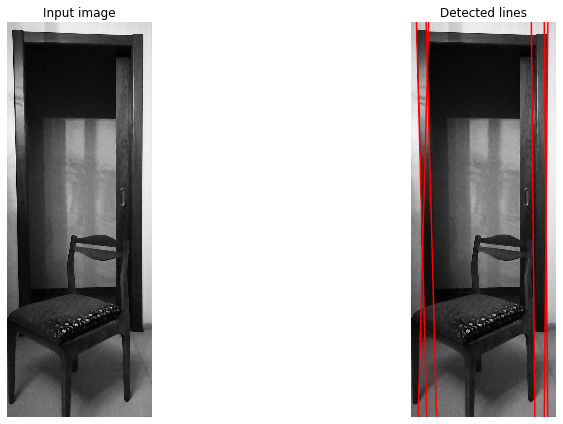

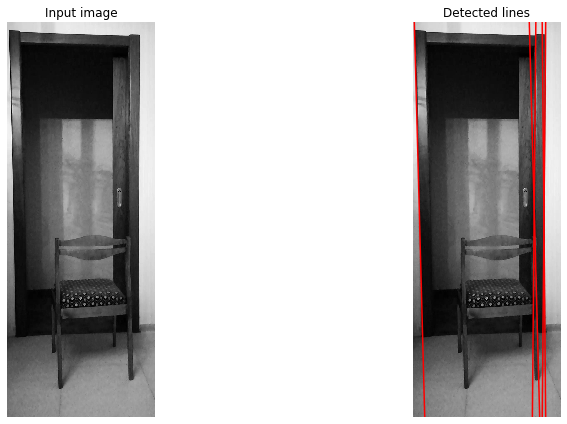

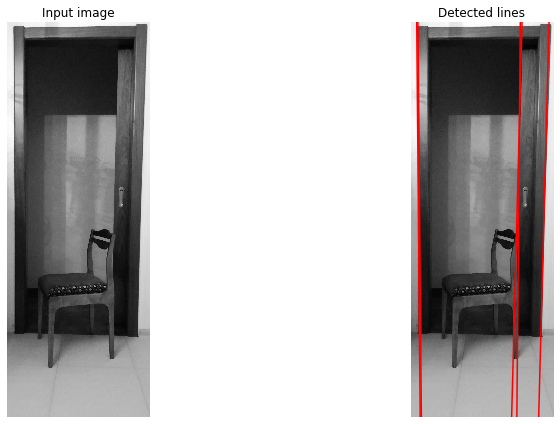

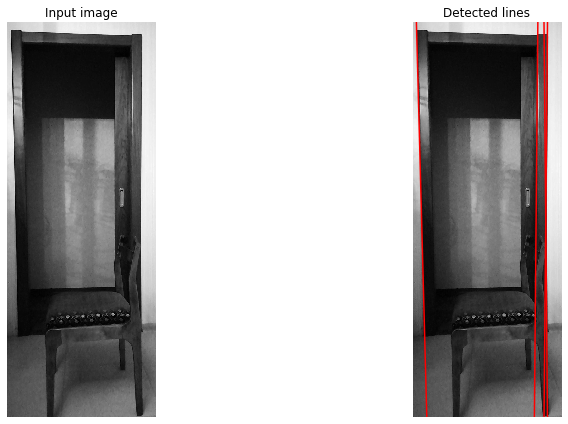

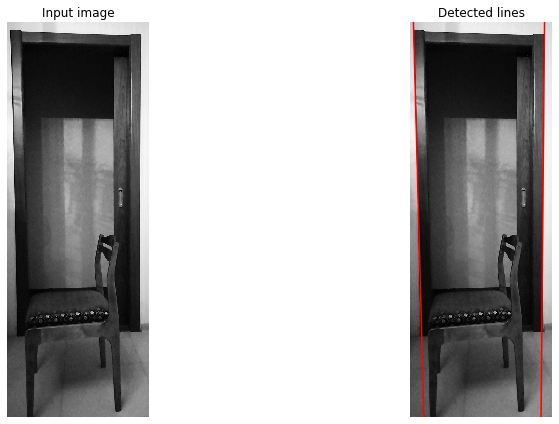

[0.9066045340836393,
 0.8901893701689462,
 0.9274949578449978,
 0.8850978804601295,
 0.923525809307968]

In [18]:
sample_size = 5
label = "yes"
find_each_door_width(label, sample_size, output=True)

Вполне приемлемо. Этот способ будет выбран для детектирования двери.

Ширина двери высчитывается относительно ширины картинки. Берём самую левую и правую прямые, находим расстояние между ними, делим на ширину картинки.

## Тестирование итогового алгоритма

In [19]:
def test_algo(directory, label, sample_size, threshold, templates_path, templates_total):    
    correct_answers = 0
    
    chairs_width = find_each_door_width(label, sample_size, output=False)
    doors_width = find_each_chair_width(label, sample_size, output=False)
    pred_labels = []
    
    for i in range(0, len(chairs_width)):
        if chairs_width[i] > doors_width[i]:
            pred_labels.append("yes")
        else:
            pred_labels.append("no")
            
    matches = [pred == label for i, pred in enumerate(pred_labels)]
    print(matches)

    correct_answers = 0
    for ans in matches:
        if ans == True:
            correct_answers += 1
    
    return correct_answers

In [21]:
sample_size_no = 15
sample_size_yes = 35

correct_ans_yes = test_algo(directory=directory, label="yes", sample_size=sample_size_yes, threshold=GOOD_MATCH_THRESHOLD, 
                            templates_path=os.path.join("data", "single_chair"), templates_total=25)

correct_ans_no = test_algo(directory=directory, label="no", sample_size=sample_size_no, threshold=GOOD_MATCH_THRESHOLD, 
                           templates_path=os.path.join("data", "single_chair"), templates_total=25)

accuracy = (correct_ans_no + correct_ans_yes) / (sample_size_no + sample_size_yes)
print("accuracy = ", accuracy)

test № 1
test № 2
test № 3
test № 4
test № 5
test № 6
test № 7
test № 8
test № 9
test № 10
test № 11
test № 12
test № 13
test № 14
test № 15
test № 16
test № 17
test № 18
test № 19
test № 20
test № 21
test № 22
test № 23
test № 24
test № 25
test № 26
test № 27
test № 28
test № 29
test № 30
test № 31
test № 32
test № 33
test № 34
test № 35
[True, True, True, True, True, True, False, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True]
test № 1
test № 2
test № 3
test № 4
test № 5
test № 6
test № 7
test № 8
test № 9
test № 10
test № 11
test № 12
test № 13
test № 14
test № 15
[True, True, False, True, True, True, False, False, True, True, False, True, True, True, True]
accuracy =  0.8


Получена точность 80%